# Red neuronal convolucional simple

- 2 capas de convolución + ReLu + Max Pooling
- 2 capas totalmente conectadas

In [162]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops

In [163]:
session = tf.Session()

In [164]:
data_dir = "../../datasets/MNIST_data/"
mnist = input_data.read_data_sets(data_dir, one_hot=False)

Extracting ../../datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


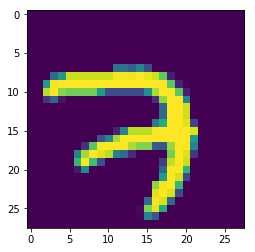

In [165]:
x_train = np.array([x.reshape(28,28) for x in mnist.train.images])
plt.imshow(x_train[0])

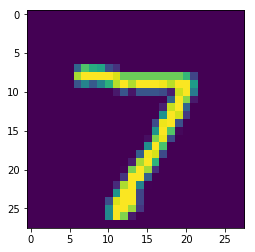

In [166]:
x_test = np.array([x.reshape(28,28) for x in mnist.test.images])
plt.imshow(x_test[0])

In [167]:
y_train = mnist.train.labels
y_test = mnist.test.labels

In [168]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [169]:
x_train.shape, y_train.shape

((55000, 28, 28), (55000,))

In [177]:
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = x_train[0].shape[0]
image_height = x_train[0].shape[1]
target_size = max(y_train) + 1
num_channels = 1 # Escala de grises
generations = 500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2
max_pool_size2 = 2
full_connected_size1 = 100

In [178]:
x_input_shape = (batch_size, image_width, image_height, num_channels)

# Creamos placeholders distintos para entrenamiento y test, con el objetivo de evitar que se sobreescriban 
# los datos, como puede pasar si declaramos un único placeholder

x_input = tf.placeholder(shape=x_input_shape, dtype=tf.float32)
y_target = tf.placeholder(shape=(batch_size), dtype=tf.int32)

eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
eval_input = tf.placeholder(shape=eval_input_shape, dtype=tf.float32)
eval_target = tf.placeholder(shape=(evaluation_size), dtype=tf.int32)

In [179]:
conv1_weight = tf.Variable(tf.truncated_normal(shape=[4,4,num_channels,conv1_features], # 4x4 es el tamaño del filtro
                                               stddev=0.1, 
                                               dtype=tf.float32)) 
conv1_bias = tf.Variable(tf.zeros(shape=[conv1_features], dtype=tf.float32))

conv2_weight = tf.Variable(tf.truncated_normal(shape=[4,4,conv1_features, conv2_features]))
conv2_bias = tf.Variable(tf.zeros(shape=[conv2_features]))

In [180]:
resulting_width = image_width // (max_pool_size1*max_pool_size2) # 28 / (2*2) = 7 (// para división entera)
resulting_height = image_height // (max_pool_size1*max_pool_size2)

# Número de parámetros de entrada de la primera capa totalmente conectada
full1_input_size = resulting_width*resulting_height*conv2_features
full1_weight = tf.Variable(tf.truncated_normal(shape=[full1_input_size, full_connected_size1], 
                                               stddev=0.1, 
                                               dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal(shape=[full_connected_size1], stddev=0.1, dtype=tf.float32))

full2_weight = tf.Variable(tf.truncated_normal(shape=[full_connected_size1, target_size], 
                                               stddev=0.1, 
                                               dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal(shape=[target_size], stddev=0.1, dtype=tf.float32))

In [181]:
def my_conv_neural_network(input_data):
    # Primera capa de convolución + ReLu + Maxpool
    conv1 = tf.nn.conv2d(input=input_data, 
                         filter=conv1_weight, 
                         strides=[1,1,1,1], 
                         padding="SAME")
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias)) # Suma el bias y, a continuación, hace el ReLu
    maxpool1 = tf.nn.max_pool(value=relu1, 
                              ksize=[1, max_pool_size1, max_pool_size1, 1], 
                              strides=[1, max_pool_size1, max_pool_size1, 1], 
                              padding="SAME")
    
    # Segunda capa de convolución
    conv2 = tf.nn.conv2d(input=maxpool1, filter=conv2_weight, strides=[1,1,1,1], padding="SAME")
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    maxpool2 = tf.nn.max_pool(value=relu2, 
                              ksize=[1, max_pool_size2, max_pool_size2, 1], 
                              strides=[1, max_pool_size2, max_pool_size2, 1], 
                              padding="SAME")
    
    # Operción de flattening para aplanar la imagen en un vector
    final_conv_shape = maxpool2.get_shape().as_list()
    final_shape = final_conv_shape[1]*final_conv_shape[2]*final_conv_shape[3]
    flat_output = tf.reshape(maxpool2, [final_conv_shape[0], final_shape])
    
    # Tercera capa, totalmente conectada
    fully_layer1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    
    #Última capa, totalmente conectada
    fully_layer2 = tf.add(tf.matmul(fully_layer1, full2_weight), full2_bias)
    
    return fully_layer2

In [182]:
model_output = my_conv_neural_network(x_input)
test_model_output = my_conv_neural_network(eval_input)

In [183]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))

In [184]:
# Aplicamos un softmax para prescindir de las probabilidades y pasar directamente a la categoría
prediction = tf.nn.softmax(model_output) 
test_prediction = tf.nn.softmax(test_model_output)

def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    acc = tf.reduce_mean(tf.cast(tf.equal(batch_predictions, targets), tf.float32))
    # num_corrects = np.sum(np.equal(batch_predictions, targets))
    # return 100.0*num_corrects/batch_predictions.shape[0]
    return acc

In [185]:
train = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(loss)

In [186]:
init = tf.global_variables_initializer()
session.run(init)

In [ ]:
train_loss = []
train_acc = []
test_acc = []

for i in range(generations):
    rand_idx = np.random.choice(len(x_train), size=batch_size)
    rand_x = np.expand_dims(x_train[rand_idx], 3) # Añadimos los canales de color en el index 3
    rand_y = y_train[rand_idx]
        
    train_dict = {x_input: rand_x, y_target: rand_y}    
    session.run(train, feed_dict=train_dict)
    
    temp_train_loss, temp_train_preds = session.run([loss, prediction], feed_dict=train_dict)
    temp_train_acc = session.run(get_accuracy(temp_train_preds, rand_y))
    
    train_loss.append(temp_train_loss)
    train_acc.append(temp_train_acc)
    
    # Evaluamos cada 50 iteraciones
    if (i+1)%eval_every == 0:
        rand_idx_eval = np.random.choice(len(x_test), size=evaluation_size)
        rand_x_eval = np.expand_dims(x_test[rand_idx_eval], 3) # Añadimos los canales de color en el index 3
        rand_y_eval = y_test[rand_idx_eval]

        test_dict = {eval_input: rand_x_eval, eval_target: rand_y_eval}

        temp_test_preds = session.run(test_prediction, feed_dict=test_dict)
        temp_test_acc = session.run(get_accuracy(temp_test_preds, rand_y_eval))
        test_acc.append(temp_test_acc)
        
        print("Step #{} ==> Loss: {}, Accuracy: {}".format(i+1, temp_train_loss, temp_train_acc))

Step #5 ==> Loss: 2.302048921585083, Accuracy: 0.33000001311302185
Step #10 ==> Loss: 1.890992283821106, Accuracy: 0.33000001311302185
Step #15 ==> Loss: 1.3369841575622559, Accuracy: 0.5699999928474426
Step #20 ==> Loss: 1.2255752086639404, Accuracy: 0.6499999761581421
Step #25 ==> Loss: 0.7444543242454529, Accuracy: 0.7400000095367432
Step #30 ==> Loss: 0.5717993378639221, Accuracy: 0.8399999737739563
Step #35 ==> Loss: 0.5130689740180969, Accuracy: 0.8299999833106995
Step #40 ==> Loss: 0.5476437211036682, Accuracy: 0.8500000238418579
Step #45 ==> Loss: 0.32026931643486023, Accuracy: 0.8999999761581421
Step #50 ==> Loss: 0.5307966470718384, Accuracy: 0.8399999737739563
Step #55 ==> Loss: 0.4470352828502655, Accuracy: 0.8600000143051147
Step #60 ==> Loss: 0.24950730800628662, Accuracy: 0.9399999976158142
Step #65 ==> Loss: 0.40268751978874207, Accuracy: 0.8899999856948853
Step #70 ==> Loss: 0.550870418548584, Accuracy: 0.8600000143051147
Step #75 ==> Loss: 0.3942861557006836, Accuracy